In [1]:
#Adapted from Chap 6
#also could be useful
#https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

In [1]:
import torch
import json
import random as ra

import torch
from tqdm import tqdm
from torch.nn.utils.rnn import pack_padded_sequence

import numpy as np

exec(open("01-utilities.py").read())
exec(open("05-utilities.py").read())

In [2]:
#load data
segments = json.load(open('./LSTM_DATA.json'))

In [3]:
#print data info
print('number of code snippet samples:',len(segments))
#total samples wtihin snippets
count = 0
#find number of samples in a snippet
for s in segments:
    count+=len(segments[s]['x'])

print('number of total samples from parsed snippets:',count)

number of code snippet samples: 10000
number of total samples from parsed snippets: 2036850


In [4]:
l = np.random.choice(range(0,100),4)
l[0] in l

True

In [4]:
def get_sampled_indexes(segment_len,num,frac=False):
    if frac:
        sampled_indexes = np.random.choice(range(0,segment_length),int(segment_length/num))
    else:
        sampled_indexes = np.random.choice(range(0,segment_length),num)
        
    return sampled_indexes

In [5]:
#split the data

train_x=[]
train_y=[]
val_x = []
val_y = []
test_x = []
test_y = []

num_train = 8000
num_val   = 1000
num_test  = 1000
mult = 1 #serves to increase the number of samples and number sampled from data

for s in segments:
    
    #only use X amount of data from each segment
    #to reduce data size and train on more samples (so more representive of whole data set)
    segment_length = len(segments[s]['x'])
    sampled_indexes = get_sampled_indexes(segment_length,mult)
    
    for ix,x in enumerate(segments[s]['x']):
        
        y = segments[s]['y'][ix]
        
        #must be of correct shape to be used
        if len(x)==41 and len(y)==41 and ix in sampled_indexes:
            if len(train_x)<num_train*mult:
                train_x.append(x)
                train_y.append(y)
            elif len(val_x)<num_val*mult:
                val_x.append(x)
                val_y.append(y)
            elif len(test_x)<num_test*mult:
                test_x.append(x)
                test_y.append(y)
            else:
                #extra data
                pass
            

In [6]:
print('Data Set Up')
print('number of training samples:',len(train_x))
print('number of validation samples:',len(val_x))
print('number of testing samples:',len(test_x))

Data Set Up
number of training samples: 8000
number of validation samples: 1000
number of testing samples: 963


In [7]:
class code_snippet_loader(torch.utils.data.Dataset):
    """
    A PyTorch Dataset wrapper for the code segmentation dataset as an LM!
    """
    def __init__(self,x,y):
        # set up our data containers 
        # note: we will be creating a list of tensors
        self.x = torch.LongTensor(x)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        # the length of our dataset is simply 
        # the number of samples!
        return len(self.x)

    def __getitem__(self, item):
        # when calling a specific example,
        # we return the input, which is also the gold label!
        return {'x': self.x[item],
                'y': self.y[item]} 


In [8]:
LM_train_loader = code_snippet_loader(train_x, train_y)
LM_val_loader = code_snippet_loader(val_x, val_y)
LM_test_loader = code_snippet_loader(test_x, test_y)

In [9]:
# considering what our new input, target pairs look like:
len(LM_train_loader.x), LM_train_loader[29]

(8000,
 {'x': tensor([   3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
             8,    7,   90,  275,    3,   11,    3,   90,  275,    4,    3,    3,
             3,    3,    3,    3,    3,    3,    8,    7,  598, 5477,  227, 7298,
             3,    3,    3,    3,   11]),
  'y': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.])})

In [10]:
torch.manual_seed(691)

#vocab size from sentence peice
#vocab dim???? 
vocab_size = 10000 #same as sentence peice
vocab_dim = 50  # the size of our pre-trained word vectors

# randomly initialize our word vectors!
vocab_dim = 256
word_vectors = torch.randn(vocab_size, vocab_dim)
word_vectors.shape, word_vectors

(torch.Size([10000, 256]),
 tensor([[ 1.1349,  0.2690, -0.0750,  ...,  0.0429, -0.9033,  0.0262],
         [-0.4227, -0.1305, -0.4603,  ...,  0.0699,  1.8887,  0.3866],
         [-0.8391, -0.2705,  0.1654,  ...,  0.7996, -0.4978,  0.0319],
         ...,
         [ 0.8728, -0.3543,  1.5440,  ...,  0.9600, -1.5825,  2.0992],
         [ 0.0453, -0.2548, -0.2832,  ...,  1.9181,  1.5490,  0.2397],
         [ 0.2698,  0.7229, -0.8933,  ..., -0.5346, -1.9112,  0.4954]]))

In [11]:
def train_lm(model, train_data, val_data, word_vectors,
             batch_size=50, lr=0.01, mu=0.25):
    # setup our optimizer and loss function
    opt = torch.optim.Adagrad(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss(reduction='sum')
    #loss_fn = nn.CrossEntropyLoss(reduction='sum')

    torch.manual_seed(691)
    
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

    epoch = 0
    no_imp = 0
    patience=5
    
    # max_epoch turns off early stopping, when set
    max_epochs = 250 #100 #50
    training = True
    best_val_loss = None
    
    history = {}
    
    training=True

    #while (training and not max_epoch) or (epoch < max_epoch):
    #while training and epoch < max_epoch:
    while epoch < max_epochs and no_imp < patience:
        print(f'Start epoch {epoch + 1}')

        # Turn on training mode which enables dropout.
        model.train()
        train_loss = 0
        vocab_size = word_vectors.shape[0]
        #print('----')

        for i, batch in enumerate(train_loader):
            ###
            ###MAKE SOME PRINTOUTS
            ###
            # clear any remaining gradients
            model.zero_grad()
            
            # forward pass
            y_preds, h = model(to_gpu(batch['x']))
            

            # calculate loss
            loss = loss_fn(y_preds.view(-1), to_gpu(batch['y'].view(-1)))
            train_loss += loss.cpu().item()
            #print(train_loss)
            
            # Calculate the gradients
            loss.backward()
        
            # `clip_grad_norm` applies gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), mu)

            # update the parameteres yet after clipping
            opt.step()

        print(f'Current train loss: {train_loss:.2f}')
        print(f'Average per sample train loss: {(train_loss/num_train):.2f}')

        # disable gradients during validation
        model.eval()

        val_loss = 0
        for batch in val_loader:
            y_preds, h = model(to_gpu(batch['x']))
            val_loss += loss_fn(y_preds.view(-1), to_gpu(batch['y'].view(-1))).cpu().item()

        print(f'Total validation loss: {val_loss:.2f}')
        print(f'Average per sample validation loss: {(val_loss/num_val):.2f}')
        
        if best_val_loss is None or val_loss < best_val_loss:
            best_val_loss = val_loss
            no_imp = 0
            torch.save(model.state_dict(), './data/biLSTM_LM.pt')
        else:
            no_imp += 1

        print(f'Best validation loss: {best_val_loss:.2f} (Epochs without improvement: {no_imp})')
        
        '''
        if not best_val_loss:
            best_val_loss = val_loss
        elif val_loss < best_val_loss:
            best_val_loss = val_loss
        else:
            print('No improvement! Early stopping')
            training = False
        '''

    
        epoch += 1
        
        history['epoch_'+str(epoch)]={'train_loss':train_loss,'val_loss':val_loss}
        print()

    return model,history

In [12]:

###
# adapted from the PyTorch examples. for the full PyTorch LM example, see: 
# https://github.com/pytorch/examples/blob/master/word_language_model/model.py
###

import torch.nn as nn

class LSTM_LM(nn.Module):
    """Model feeds pre-trained embeddings through a series of biLSTM
       layers, followed by a linear vocabulary decoder."""
    
    def __init__(self, in_dim, hidden_dim, lstm_layers, word_vectors, 
                 dropout=0.05, bidirectional = True):
        super(LSTM_LM, self).__init__()

        self.vocab_size = word_vectors.shape[0]
        self.hidden_dim = hidden_dim
        self.lstm_layers = lstm_layers

        # blank embed layer starting from GloVe pre-trained vectors
        self._embed = nn.Embedding.from_pretrained(word_vectors, freeze=False)        
        self._drop = nn.Dropout(dropout)

        self._lstm = nn.LSTM(in_dim, hidden_dim, num_layers = lstm_layers, dropout = dropout,
                             bidirectional = bidirectional, batch_first=True)
        self._ReLU = nn.ReLU()
        self._pred = nn.Linear((2 if bidirectional else 1)*hidden_dim, 
                               #self.vocab_size)
                               1) #only 1 or zeros here 

    def forward(self, x):
        e = self._drop(self._embed(x))
        z, h = self._lstm(e)
        z_drop = self._drop(z)
        s = self._pred(self._ReLU(z_drop))
        #s = s.view(-1, self.vocab_size)
        s = s.squeeze()
        return s, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters())
        return weight.new_zeros(self.lstm_layers, batch_size, self.hidden_dim)

In [13]:
hidden_dim = 200
lstm_layers = 2
#LSTM_LM_net = to_gpu(LSTM_LM(newstweet_wvs.shape[1], hidden_dim,lstm_layers, newstweet_wvs))
LSTM_LM_net = LSTM_LM(word_vectors.shape[1], hidden_dim,lstm_layers, word_vectors)

LSTM_LM_net

LSTM_LM(
  (_embed): Embedding(10000, 256)
  (_drop): Dropout(p=0.05, inplace=False)
  (_lstm): LSTM(256, 200, num_layers=2, batch_first=True, dropout=0.05, bidirectional=True)
  (_ReLU): ReLU()
  (_pred): Linear(in_features=400, out_features=1, bias=True)
)

In [14]:
#batch_size = 50 
batch_size = 50

# an initial learning rate, prior to clipping
lr = 0.0005
#lr = 0.01

# the clipping theshold
mu = 0.25

#LSTM_LM_net_trained, history = train_lm(LSTM_LM_net, LM_train_loader, LM_val_loader, word_vectors, batch_size=batch_size, lr=lr, mu=mu)


In [23]:
#start around 10:20

In [22]:
# [depricated] saving the biLSTM's weights
# ...we now have save best in training
#torch.save(LSTM_LM_net_trained.state_dict(), './data/biLSTM_LM.pt')

In [19]:
import matplotlib.pyplot as plt

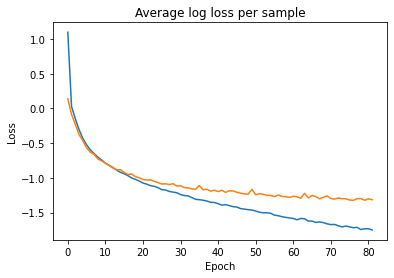

In [26]:
training_loss_values = []
validation_loss_values = []
for loss in history:
    
    #normal
    #training_loss_values.append(history[loss]['train_loss'])
    #validation_loss_values.append(history[loss]['val_loss'])
    #
    #adjusted normal
    #training_loss_values.append(history[loss]['train_loss']/num_train)
    #validation_loss_values.append(history[loss]['val_loss']/num_val)
    #
    #log
    #training_loss_values.append(np.log(history[loss]['train_loss']))
    #validation_loss_values.append(np.log(history[loss]['val_loss']))
    #
    #adjusted log
    #training_loss_values.append(np.log(history[loss]['train_loss']/num_train))
    #validation_loss_values.append(np.log(history[loss]['val_loss']/num_val))


Epochs = range(len(training_loss_values))


#show all
plt.plot(Epochs, training_loss_values)
plt.plot(Epochs, validation_loss_values)
#show all but the first one
#plt.plot(Epochs[1:], training_loss_values[1:])
#plt.plot(Epochs[1:], validation_loss_values[1:])
plt.title('Average log loss per sample')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
    
    

In [17]:
########
## use saved model
#######

#set up model
hidden_dim = 200
lstm_layers = 2
LSTM_LM_net_trained = LSTM_LM(word_vectors.shape[1], hidden_dim,lstm_layers, word_vectors)

#[TODO]: fix so it works
#https://pytorch.org/tutorials/beginner/saving_loading_models.html
#https://stackoverflow.com/questions/61242966/pytorch-attributeerror-function-object-has-no-attribute-copy

#load weights into model
LSTM_LM_net_trained.load_state_dict(torch.load('./data/biLSTM_LM.pt'))
LSTM_LM_net_trained.eval()

LSTM_LM(
  (_embed): Embedding(10000, 256)
  (_drop): Dropout(p=0.05, inplace=False)
  (_lstm): LSTM(256, 200, num_layers=2, batch_first=True, dropout=0.05, bidirectional=True)
  (_ReLU): ReLU()
  (_pred): Linear(in_features=400, out_features=1, bias=True)
)

Accuracy: 0.997868074414355
Area under curve: 0.9991360678185844


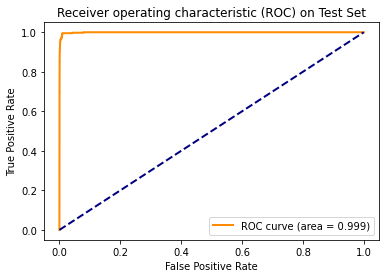

In [20]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
import sklearn.metrics as metrics
import numpy

test_loader = torch.utils.data.DataLoader(LM_test_loader, batch_size=num_test, shuffle=True)

# calculate the fpr and tpr for all thresholds of the classification
for batch in test_loader:
    
    #get predicted values
    y_preds, h = LSTM_LM_net_trained(batch['x'])
    y_preds = torch.flatten(torch.sigmoid(y_preds))
    y_preds= y_preds.detach().numpy()
    
    #get true values
    y = batch['y'].view(-1)
    y = y.detach().numpy()
    
    #accuracy
    acc = metrics.accuracy_score(y, numpy.rint(y_preds))
    
    # Compute ROC curve and ROC area for each class
    fpr, tpr, threshold = metrics.roc_curve(y, y_preds)
    
    roc_auc = metrics.auc(fpr, tpr)
    

print('Accuracy:',acc)
print('Area under curve:',roc_auc)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) on Test Set')
plt.legend(loc="lower right")
plt.show()
    

In [21]:
#from code segmentation file
import sentencepiece as spm
class Tokenizer:

    def __init__(self, filepath='python_tokenizer_30k.model'):
        self.sp = spm.SentencePieceProcessor(model_file=filepath)

    def encode(self, text, t=int):
        return self.sp.encode(text, out_type=t)

    def decode(self, pieces):
        return self.sp.decode(pieces)

    @staticmethod
    def train(input_file='data/raw_sents.txt', model_prefix='sp_model', vocab_size=30522):
        spm.SentencePieceTrainer.train(input=input_file, model_prefix=model_prefix, vocab_size=vocab_size,
                                       #input_sentence_size=2 ** 16, shuffle_input_sentence=True)
                                       input_sentence_size=number_of_lines, shuffle_input_sentence=True)
        
        #instantiate tokenizer model
tokenizer = Tokenizer('python_tokenizer.model')
        
        
        

Accuracy: 0.9789135096497498
Area under curve: 0.9933906632102283


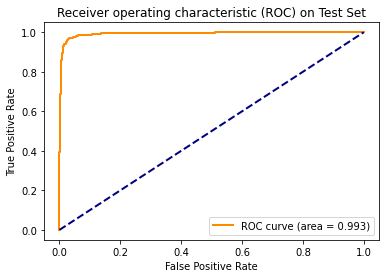

In [30]:
#make a _NEW_LINE_ ROC curve since thats what we care about
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
import sklearn.metrics as metrics

test_loader = torch.utils.data.DataLoader(LM_test_loader, batch_size=num_test, shuffle=True)

# calculate the fpr and tpr for all thresholds of the classification
for batch in test_loader:
    
    #get predicted values
    y_preds, h = LSTM_LM_net_trained(batch['x'])
    y_preds = torch.flatten(torch.sigmoid(y_preds))
    y_preds= y_preds.detach().numpy()
    
    #get true values
    y = batch['y'].view(-1)
    y = y.detach().numpy()
    
    #filter for only new line places (get info from batch['x'])
    new_y=[]
    new_y_preds=[]
    tokens = torch.flatten(batch['x']).detach().numpy()
    for i in range(len(tokens)):
        tok_literal=tokenizer.decode(int(tokens[i]))
        if tok_literal[-7:]=='NEWLINE':
            new_y.append(y[i])
            new_y_preds.append(y_preds[i])
            
    #accuracy
    #https://numpy.org/doc/stable/reference/generated/numpy.rint.html
    acc = metrics.accuracy_score(new_y, numpy.rint(new_y_preds))
            
    # Compute ROC curve and ROC area for each class
    fpr, tpr, threshold = metrics.roc_curve(new_y, new_y_preds)
    
    roc_auc = metrics.auc(fpr, tpr)

print('Accuracy:',acc)
print('Area under curve:',roc_auc)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) on Test Set')
plt.legend(loc="lower right")
plt.show()

In [22]:
#gets all predictions from one window
def get_window_predictions(window, model):
    preds, h = model(torch.tensor([window]))
    preds = torch.flatten(torch.sigmoid(preds))
    preds = preds.detach().numpy()
    return preds

get_window_predictions(test_x[0],LSTM_LM_net_trained)

array([3.3246732e-04, 6.8057285e-05, 4.6622394e-05, 5.3289965e-05,
       3.4309429e-05, 4.0225706e-05, 3.5821889e-05, 3.6674777e-05,
       3.1911710e-05, 3.1428186e-05, 3.1569878e-05, 2.2626086e-04,
       3.3227090e-05, 3.0313451e-05, 2.9997007e-05, 3.0455869e-05,
       3.0596679e-05, 3.0710980e-05, 3.0783285e-05, 3.5856443e-05,
       3.4031600e-05, 4.3347965e-05, 4.4493605e-05, 4.7247213e-05,
       4.8267189e-05, 4.3821961e-05, 4.0848467e-05, 4.1946729e-05,
       5.0756982e-05, 4.5033987e-05, 4.2970099e-05, 3.8045302e-05,
       3.7022382e-05, 3.7592112e-05, 8.0860930e-04, 4.4903576e-05,
       3.9319704e-05, 4.0494706e-05, 4.6082681e-05, 1.2923489e-04,
       2.1340436e-04], dtype=float32)

In [23]:
import math

#NOTE, THIS ONLY GETS THE PREDICTED BREAK POINTS FROM A PREDICTION
#WITH THE NEWLINE TOKEN AT CENTER OF WINDOW
def get_predicted_break_points(code_windows, model):
    start = 0
    code  =[]
    break_points = []
    print(len(code_windows))
    for window_i in range(len(code_windows)):
        #get window, which has our tokens
        window = code_windows[window_i]
        window_predictions = get_window_predictions(window,model)
        #mid = math.ceil(len(window)/2)
        mid = int(len(window)/2) #actually we need to round down...
        mid_token = tokenizer.decode(int(window[mid]))
        mid_pred = window_predictions[mid]
        if mid_token[-7:]=='NEWLINE':
            if round(mid_pred) == 1:
                break_points.append(window_i)
                
                
        code.append(mid_token)
        start+=1
    return code, break_points
    
#code_windows = segments['0']['x']
#code, breaks = get_predicted_break_points(code_windows,LSTM_LM_net_trained)
#print(breaks)

In [24]:
#from code segmentation file
def insert_comments(code, break_spots, comment='\n'+'*'*8+'\n',at_begining=True):
    #if there is a a comment at begining of snippet
    if at_begining:
        #adds a notation to add a 0
        #at beigning of break spots too
        break_spots.insert(0,0)
    
    #go through breaks backwards
    #so as not to mess up break 
    #spots as we would if we went forward
    for b in break_spots[::-1]:
        code.insert(b,comment)
    return code

In [25]:
num_samples=1
i = np.random.choice(range(0,segment_length),num_samples)
code_windows = segments[str(i[0])]['x']

code, breaks = get_predicted_break_points(code_windows,LSTM_LM_net_trained)

#from code segmentation file
comments_added = insert_comments(code,breaks)
comments_added_decoded = tokenizer.decode(comments_added)
comments_added_token_string = ''.join(comments_added_decoded)
comments_added_token_string = comments_added_token_string.replace('SPACE',' ')
comments_added_token_string = comments_added_token_string.replace('NEWLINE','\n')
comments_added_token_string = comments_added_token_string.replace('TAB','\t')
print(comments_added_token_string)

192

********
  def testSyncRetryException(self):
    
    stage = SyncForcesRetry()
    self.assertRaises(pipeline.Retry, self.run_pipeline, stage)

********

    def __call__(self, inputs, state, scope=None):
        

        _, new_state = self._cell(inputs, state, scope)
        output = tf.concat(nest.flatten(new_state), axis=1)

        return output, new_state

********

    def mapping(self):
        
        return {}




In [26]:
#https://stackoverflow.com/questions/54145433/reading-csv-file-line-by-line-and-save-lines-which-are-satisfying-certain-condit
import pandas as pd
df = pd.read_csv("gcj2008.csv")

headers = []

for header in df:
    headers.append(header)
    
print(headers)

['Unnamed: 0', 'year', 'round', 'username', 'task', 'solution', 'file', 'full_path', 'flines']


In [57]:
#get all python files and associated task
def get_GCJ_code(sample_number = 0):
    code = ''
    sample=sample_number
    count=0
    for i in range(len(df['flines'])):
        file_name = df['file'][i]
        file_type = file_name.split('.')[-1]
        if file_type == 'py':
            count+=1
            if sample==count:
                code+=df['flines'][i]
                break
    return code

In [54]:
def centered_sliding_window(token_list, window_diamiter,encode=False,PAD='unk'):
    windows = []
    for i in range(len(token_list)):
        
        #print(token_list)
        #input()
        
        window = []
        
        #if we have to pad the begining
        if i < window_diamiter:
            before_len = window_diamiter-i
            before = [PAD]*before_len+token_list[0:i]
        else:
            before = token_list[i-window_diamiter:i]
        
        #if we have to pad the end
        if i+window_diamiter>=len(token_list):
            after_len = (i+1+window_diamiter)-len(token_list)
            after = token_list[i+1:i+1+window_diamiter]+[PAD]*after_len

        else:
            after = token_list[i+1:i+1+window_diamiter]
        
        #put it togeather
        #print('------')
        #print('before:',before)
        #print('center:',token_list[i])
        #print('after:',after)
        window = before + [token_list[i]] + after
        #for encoding code if we want
        if encode:
            new_window = []
            #print(window)
            #input()
            for i in window:
                encoded = tokenizer.encode(i)
                if len(encoded)>1:       
                    x=encoded[1]
                    if type(x)==list:
                        new_window.append(x[0])
                    else:
                        new_window.append(x)
                elif len(encoded)==1:
                    if type(encoded)==list:
                        new_window.append(encoded[0])
                    else:
                        new_window.append(encoded)
                else:
                    #for some reason it finds the unicode stuff __
                    pass
                    #print(window)
                    #print(i)
                    #print(encoded)
                    #input()
            #print(window)
            #print(len(window))
            #print(len(tokenizer.decode(window)))
            #print(tokenizer.decode(window))
            #print(len(tokenizer.encode(window)))
            #window = tokenizer.encode(tokenizer.decode(window))
            window = new_window
        #print(window)
        #print(len(window))
        #input()

        #save windowz
        windows.append(window)
    
    return windows


In [58]:
for i in range(100):
    print('-----------------------------------------------------')
    code = get_GCJ_code(sample_number=i)

    new_code = code.replace(' ',' SPACE')
    #newline
    new_code = new_code.replace('\n',' NEWLINE')
    #tab
    new_code = new_code.replace('\t',' TAB')

    tokens = tokenizer.encode(new_code,t=str)


    wd=20 #window diameter
    X_windows = centered_sliding_window(tokens,wd,encode=True)
    code, breaks = get_predicted_break_points(X_windows,LSTM_LM_net_trained)

    #from code segmentation file
    comments_added = insert_comments(code,breaks)
    comments_added_decoded = tokenizer.decode(comments_added)
    comments_added_token_string = ''.join(comments_added_decoded)
    comments_added_token_string = comments_added_token_string.replace('SPACE',' ')
    comments_added_token_string = comments_added_token_string.replace('NEWLINE','\n')
    comments_added_token_string = comments_added_token_string.replace('TAB','\t')
    print(comments_added_token_string)

-----------------------------------------------------
0

********

-----------------------------------------------------
575

********
#/usr/bin/env python
 
 def comb(a,  b):
 	if a < b:
 		a, b = b, a
 	bin = 1
 	for i in xrange(1, b + 1):
 		bin = (bin * (a + i)) / i
 	return bin
 
 def solve():
 	H, W, R = [ int(n) for n in raw_input().split() ]
********

 	rocks = []
 	for r in range(R):
 		rocks.append([ int(n) for n in raw_input().split() ])
 	
********

 	def rec(x, y, w, h):
 		dx = w - x
 		dy = h - y
 		n = 0
 		for a in range(dx + 1):
 			b = dx - 2 * a
 			if 0 <= b <= dy and a + 2 * b == dy:
 				n = n + comb(a, b)
 		rocksLeft = [
 			( u, v ) for u, v in rocks
 			if x < u < w and y < v < h
 			]
 		for rx1, ry1 in rocksLeft:
 			for rx2, ry2 in rocksLeft:
 				if rx2 < rx1 and ry2 < ry1:
 					break
 			else:
 				n -= rec(x, y, rx1, ry1) * rec(rx1, ry1, w, h)
 
 		return n
 	
 	return rec(1, 1, W, H) % 1000
 
 for case in range(int(raw_input())):
 	print 'Case #%d: %s

In [ ]:
#USE BREAK POINTS TO GET SNIPPETS FROM GCJ FOR NMT